# Transverse field Ising model to demo primitives

In [21]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np


SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")


def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=0, trotter_barriers=False, layer_barriers=False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    
    for step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
        
    return qc


def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers):
    # Adding R_zz in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])                    # S^\dagger
        qc.append(SYGate, [i+1])            # SY
        qc.cx(i, i+1)                       # CNOT
        qc.append(SYdgGate, [i+1])          # SY^\dagger
    
    if layer_barriers:
        qc.barrier()
    
    # Adding R_zz in the odd layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])                    # S^\dagger
        qc.append(SYGate, [i+1])            # SY
        qc.cx(i, i+1)                       # CNOT
        qc.append(SYdgGate, [i+1])          # SY^\dagger
    
    if layer_barriers:
        qc.barrier()
    
    # Rotating gate
    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
        
        

In [22]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

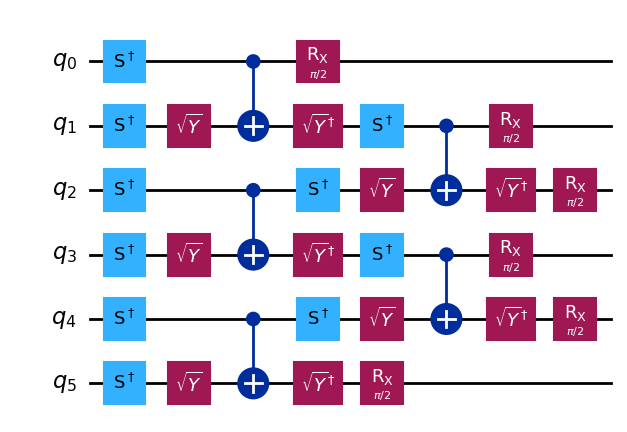

In [23]:
qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=False, layer_barriers=False)
qc.draw(output='mpl', fold=-1)

In [36]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

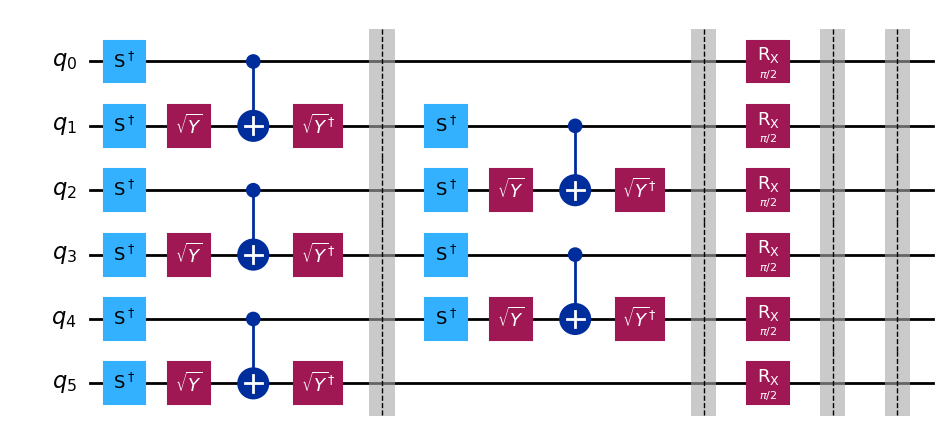

In [37]:
qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=-1)

# Demo: Sampler

In [39]:
def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=False, layer_barriers=False):
    for step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
    
    return qc


def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers=False):
    # Rotating gate
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    
    # Adding R_zz in the odd layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])            # SY
        qc.cx(i, i+1)                       # CNOT
        qc.append(SYdgGate, [i+1])          # SY^\dagger
        qc.s([i, i+1])                      # S
    
    if layer_barriers:
        qc.barrier()
    
    # Adding R_zz in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])            # SY
        qc.cx(i, i+1)                       # CNOT
        qc.append(SYdgGate, [i+1])          # SY^\dagger
        qc.s([i, i+1])                      # S
    
    if layer_barriers:
        qc.barrier()

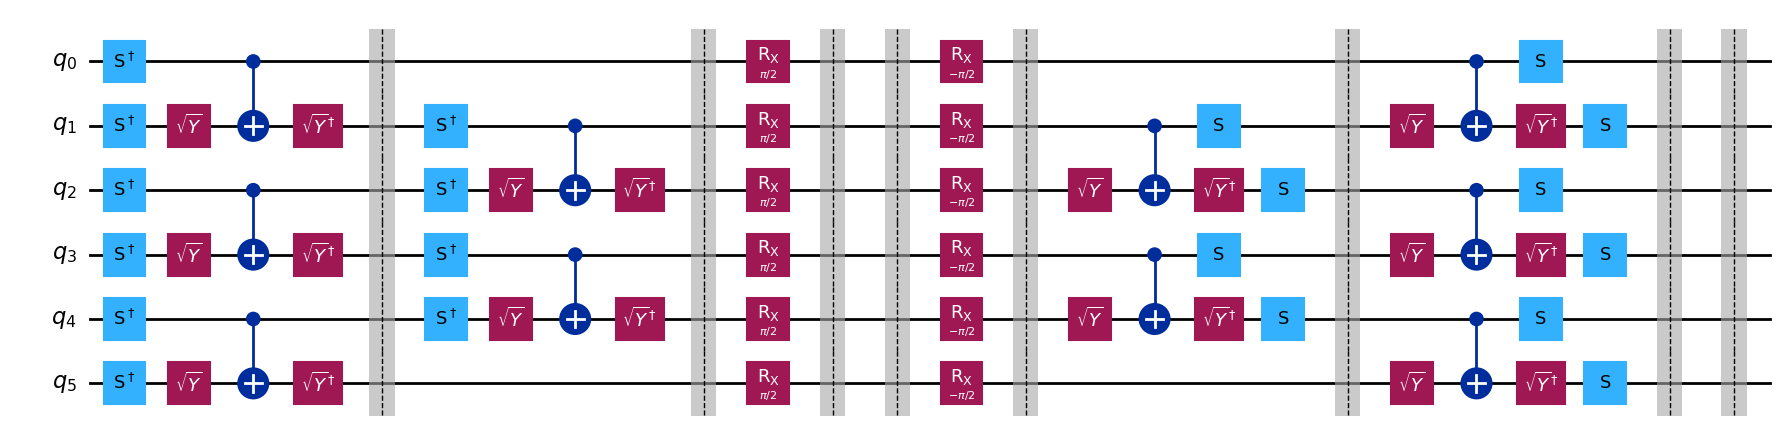

In [40]:
append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=-1)

## Step 1: Map the problem to circuits and observables

In [41]:
max_trotter_steps = 10
num_qubits = 8
measured_qubits = [4, 5]

qc_list = []
for step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps,rx_angle, num_cl_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
    append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
    qc.measure(measured_qubits, [0, 1])
    qc_list.append(qc)

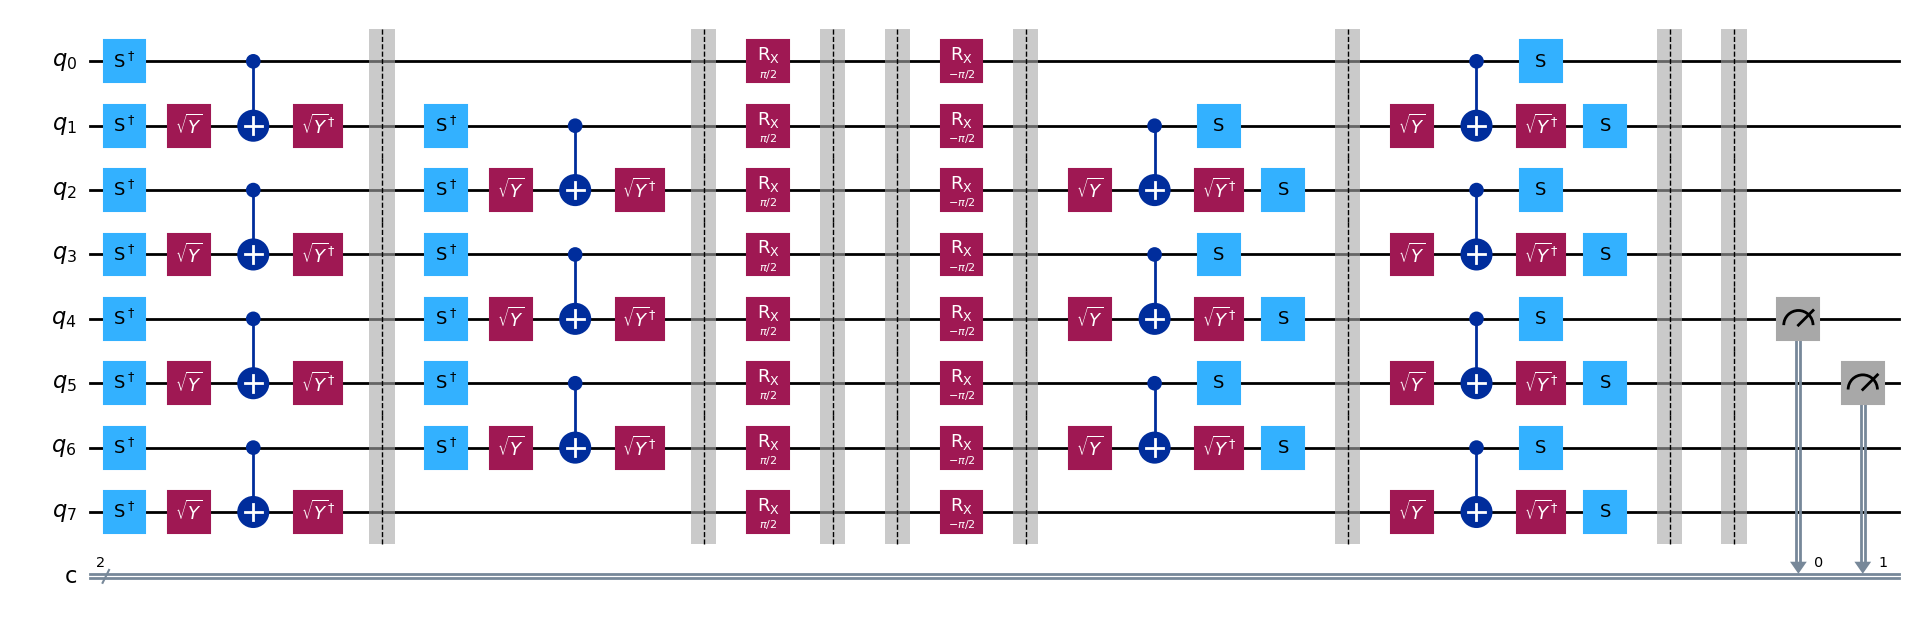

In [42]:
qc_list[1].draw(output='mpl', fold=-1)

In [44]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50]

qc_list = []
for step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps,rx_angle, num_cl_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
    append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
    qc.measure(measured_qubits, [0, 1])
    qc_list.append(qc)

## Step 2: Optimize

In [45]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend(name='ibm_osaka')
print("Done getting the backend")

# Note after filming: transpile` will be deprecated soon! so in the future, use `generate_preset_pass_manager` to achieve similar functionality
# But... in version 1.1.1 still working!
qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)

Done getting the backend


## Step 3: Execute on hardware

In [46]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpiled_list)
print(job.job_id())

/var/folders/_1/vyxw8wlj1wn0fhb6pl64k4lm0000gn/T/ipykernel_93185/2065324435.py:3: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


ctbp7nyw4dmg008c1mq0


## Step 4: Post-processing and plotting

In [53]:
job_id = "ctbp7nyw4dmg008c1mq0"
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / data.c.num_shots)
    except:
        survival_probability_list.append(0)

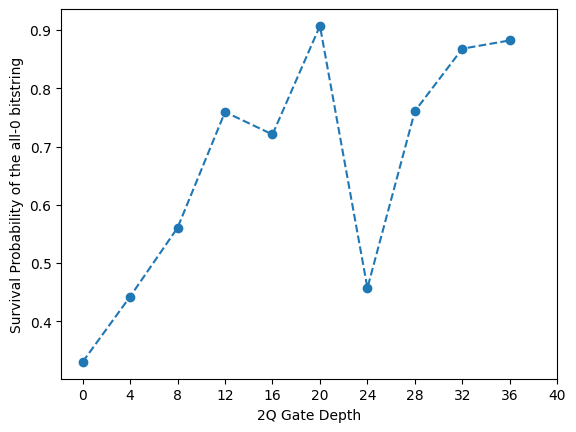

In [54]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel('2Q Gate Depth')
plt.ylabel('Survival Probability of the all-0 bitstring')
plt.xticks(np.arange(0, 44, 4))
plt.show()

### _Interlude_: What is barrier?

case 1: no barrier between Hadamard gates

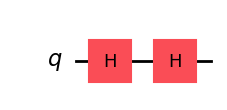

In [48]:
qc_temp = QuantumCircuit(1)
qc_temp.h(0)
qc_temp.h(0)

qc_temp.draw(output='mpl')

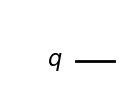

In [50]:
tqc_temp = transpile(qc_temp)

tqc_temp.draw(output='mpl')

case 2: barrier between Hadamard gates

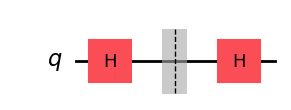

In [51]:
qc_temp = QuantumCircuit(1)
qc_temp.h(0)
qc_temp.barrier()
qc_temp.h(0)

qc_temp.draw(output='mpl')

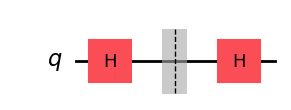

In [52]:
tqc_temp = transpile(qc_temp)

tqc_temp.draw(output='mpl')